In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
with open("img.pickle", "rb") as file:
    img = pickle.load(file)

K = img['camera_matrix']
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = img["depthPixels"].shape
intrinsics = b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0)

rgbd = b.RGBD(
    img["rgbPixels"],
    img["depthPixels"],
    b.t3d.pybullet_pose_to_transform(img["camera_pose"]),
    intrinsics
)

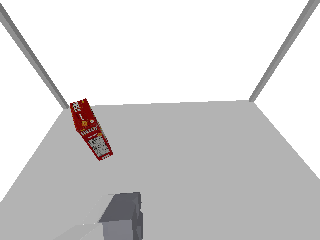

In [4]:
b.get_rgb_image(rgbd.rgb)

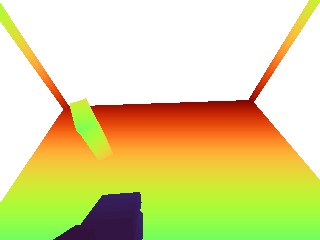

In [5]:
b.get_depth_image(rgbd.depth)

In [6]:
import pyransac3d
def find_plane(point_cloud, threshold,  minPoints=100, maxIteration=1000):
    """
    Returns the pose of a plane from a point cloud.
    """
    plane = pyransac3d.Plane()
    plane_eq, inliers = plane.fit(point_cloud, threshold, minPoints=minPoints, maxIteration=maxIteration)
    plane_pose = b.utils.plane_eq_to_plane_pose(plane_eq)
    return plane_pose, inliers

In [7]:
scaling_factor = 0.3
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd, scaling_factor)

cloud = b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3)
too_big_indices = np.where(cloud[:,2] > 3.0)
cloud = cloud.at[too_big_indices, :].set(np.nan)

table_pose, inliers = find_plane(np.array(cloud), 0.01)

In [8]:
face_child = 3

camera_pose = jnp.eye(4)
table_pose_in_cam_frame = b.t3d.inverse_pose(camera_pose) @ table_pose
if table_pose_in_cam_frame[2,2] > 0:
    table_pose = table_pose @ b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)

b.clear()
b.show_cloud("1", cloud)
b.show_pose("table", table_pose)

In [9]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)

# set inliers to zero
x_indices, y_indices = np.unravel_index(inliers, obs_img.shape[:2])
obs_img2 = obs_img.at[x_indices, y_indices, :].set(0.)#jnp.array([100.0,100.0,100.0]))

x_indices, y_indices = np.unravel_index(too_big_indices, obs_img.shape[:2])
obs_img3 = obs_img2.at[x_indices, y_indices, :].set(0.)

b.clear()
b.show_cloud("Obs without table or too-far points", obs_img3.reshape(-1,3))


In [10]:
# Add every ply file from the model dir using b.RENDERER.add_mesh_from_file(mesh_path)
b.setup_renderer(rgbd_scaled_down.intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
for model_path in glob.glob(os.path.join(model_dir, "*.ply")):
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (96, 96, 1024)


In [45]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (2.0, jnp.pi, (25, 25, 40)),
      (0.5, jnp.pi, (30,30,30)), (0.4, jnp.pi, (30, 30, 30)),
    # (0.05, jnp.pi/3, (15,15,15)),
    # (0.02, jnp.pi, (9,9,51))
    # , (0.01, jnp.pi/5, (15,15,15)),
    #   (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

_cp_to_pose = lambda cp, index: table_pose @ b.scene_graph.relative_pose_from_edge(cp, face_child, b.RENDERER.model_box_dims[index])
cps_to_pose= jax.vmap(_cp_to_pose, in_axes=(0,0,))
cps_to_pose_jit = jax.jit(cps_to_pose)
cps_to_pose_parallel = jax.vmap(cps_to_pose, in_axes=(0,None,))
cps_to_pose_parallel_jit = jax.jit(cps_to_pose_parallel)

key = jax.random.PRNGKey(30)

def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    width = 0.02
    probabilities_per_pixel = (distances < width/2) / width
    return probabilities_per_pixel.mean()

score_vmap = jax.jit(jax.vmap(score_images, in_axes=(0, None)))

def grid_and_max(key, cps, indices, number, grid, obs_img):
    cps_expanded = jnp.repeat(cps[None,...], grid.shape[0], axis=0)
    cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid)
    cp_poses = cps_to_pose_parallel(cps_expanded, indices)
    rendered_images = b.RENDERER.render_many(cp_poses, indices)[...,:3]
    scores = score_vmap(rendered_images, obs_img)
    # top 5 scores:
    best_idx = jnp.argmax(scores) # jnp.argsort(scores)[-4]
    next_best_indices = jnp.argsort(scores)[-5:-1]
    cps = cps_expanded[best_idx]
    return cps, scores[best_idx], scores[next_best_indices]

def grid_and_sample(key, cps, indices, number, grid, obs_img):
    cps_expanded = jnp.repeat(cps[None,...], grid.shape[0], axis=0)
    cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid)
    cp_poses = cps_to_pose_parallel(cps_expanded, indices)
    rendered_images = b.RENDERER.render_many(cp_poses, indices)[...,:3]
    scores = score_vmap(rendered_images, obs_img)

    norm_log_scores = scores - jax.scipy.special.logsumexp(scores)
    norm_scores = jnp.exp(norm_log_scores)
    idx = jax.random.categorical(key, norm_scores)
    cps = cps_expanded[idx]
    return cps, scores[idx], jnp.argmax(scores)

def c2f(key, potential_cps, potential_indices, number, contact_param_gridding_schedule, obs_img):
    for cp_grid in contact_param_gridding_schedule:
        potential_cps, score, score2 = grid_and_max(key, potential_cps, potential_indices, number, cp_grid, obs_img)
    return potential_cps, score, score2
c2f_jit = jax.jit(c2f)

In [46]:
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)
obs_img = obs_img3 # b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)

In [47]:
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)
obs_img = obs_img3


In [50]:
best_score = 0.0
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])

next_index = 18
potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
# potential_cps = jnp.concatenate([cps, jnp.array([[0.0, 0.0, 0.0]])])

potential_cps, score, score2 = c2f_jit(key, potential_cps, potential_indices, len(potential_indices) - 1, contact_param_gridding_schedule, obs_img)
print(score, score2)
if score > best_score:
    best_index = next_index
    best_score = score
    best_cps = potential_cps
    best_indices = potential_indices
cps = best_cps
indices = best_indices

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
poses = cps_to_pose(cps, indices)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
    b.set_pose(f"{i}", poses[i])

0.7233796 [0.7161458 0.7161458 0.7233796 0.7233796]


In [ ]:
#####################################
# Below this point is scratch work!
#####################################

In [ ]:
jnp.any(jnp.isnan(obs_img3))

Array(False, dtype=bool)

In [38]:
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)
obs_img = obs_img3

best_score = 0.0
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])

# for _ in range(10):
# for next_index in [18]: # range(len(b.RENDERER.model_box_dims)):
next_index = 18
potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
# potential_cps = jnp.concatenate([cps, jnp.array([[0.0, 0.0, 0.0]])])

key, potential_cps, potential_indices, number, contact_param_gridding_schedule, obs_img = key, potential_cps, potential_indices, len(potential_indices) - 1, contact_param_gridding_schedule, obs_img

cp_grid = contact_param_gridding_schedule[0]
key, cps, indices, number, grid, obs_img = key, potential_cps, potential_indices, number, cp_grid, obs_img

# this was done to clear memory - uncomment to fix
cps_expanded = None # jnp.repeat(cps[None,...], grid.shape[0], axis=0)
cps_expanded = None #  cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid)
cp_poses = None # cps_to_pose_parallel(cps_expanded, indices)
rendered_images = None # b.RENDERER.render_many(cp_poses, indices)[...,:3]
scores = None # score_vmap(rendered_images, obs_img)


In [36]:
scores = None
log_norm_scores = None
norm_scores = None

In [30]:
norm_log_scores = scores - jax.scipy.special.logsumexp(scores)
norm_scores = jnp.exp(norm_log_scores)
key = jax.random.split(key,2)[0]
idx = jax.random.categorical(key, scores / scores.sum())
# cps_to_pose(jnp.array([cps_expanded[idx]]), jnp.array([18]))
idx2 = jnp.argmax(scores)
poses = cps_to_pose(cps_expanded[idx2], jnp.array([18]))

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_trimesh(f"18", b.RENDERER.meshes[18])
b.set_pose(f"18", poses[0])

In [26]:
# get 100 samples from the categorical
samples = []
for _ in range(100):
    key = jax.random.split(key,2)[0]
    idx = jax.random.categorical(key, scores / scores.sum())
    samples.append(idx)
# count num unique samples:
np.unique(np.array(samples)).shape

(100,)

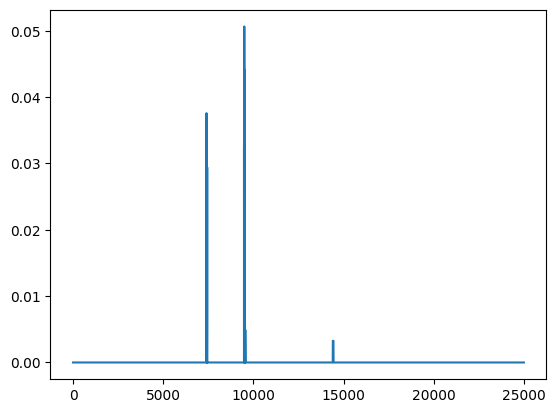

Array(0.6960785, dtype=float32)

In [27]:
ns = scores / scores.sum()
plt.plot(ns)
plt.show()
ns[ns > 0.01].sum()

In [ ]:

    
    
    
    
    
    
    
    
    
    
    
    potential_cps, score, score2 = c2f_jit(key, potential_cps, potential_indices, len(potential_indices) - 1, contact_param_gridding_schedule, obs_img)
    print(score, score2)
    if score > best_score:
        best_index = next_index
        best_score = score
        best_cps = potential_cps
        best_indices = potential_indices
cps = best_cps
indices = best_indices

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
# poses = cps_to_pose(cps, indices)
# for i in range(len(poses)):
#     b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
#     b.set_pose(f"{i}", poses[i])


Array(0, dtype=int32)